# Basic imports

In [1]:
from math import inf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
import pickle
models_prefix = './models-persisted'

def persist_instance(variable:any, file_name:str):
    if not os.path.exists(models_prefix): os.makedirs(models_prefix)

    with open(f'{models_prefix}/{file_name}.pkl', 'wb') as file:
        pickle.dump(variable, file)

def load_instance(path:str):
    with open(f'{path}', 'rb') as file:
        return pickle.load(file)

# Reading data

In [3]:
from dataController import DataController
from dataDigestor import DataDiggestor

data_path = '../data/collected_data'
data_diggestor = DataDiggestor()
initial_df = data_diggestor.diggest_files_into_single_dataframe(data_path)

data_controller = DataController(initial_df)
data_controller.df.head()

,Time,PT100 1 [ºC],PT100 2 [ºC],PT100 3 [ºC],PT100 4 [ºC],Temp. TH 1 [ºC],Umidade 1 [%],Vel. do Ar [m/s],Temp. TH 2 [ºC],Umidade 2 [%],Umidade Produto [%],Ensaio
0,0.000,24.213534,24.500000,-244.989090,1326.005777,20.134013,73.388713,1.075032,24.182938,90.653755,55.223333,0
1,900.485,27.270283,27.310531,-244.989090,1326.005777,22.176537,65.309984,1.075032,27.512709,92.391174,48.006667,0
2,1799.039,27.268392,27.397820,-244.989090,1326.005777,24.304439,58.981789,1.075032,27.571817,93.011919,41.003333,0
3,2699.241,34.421674,29.924256,1326.058821,-244.989090,25.338835,54.499243,1.075032,27.302546,93.185991,7.083333,0
4,3600.524,45.204301,43.769892,-244.989090,1326.005777,24.544156,56.508994,1.075032,39.971468,26.113811,2.283333,0


In [4]:
from sklearn.model_selection import train_test_split

interest_column = 'Umidade Produto [%]'
columns_to_drop = ['Ensaio', 'Vel. do Ar [m/s]']

X, y = data_controller.get_X_y_datasets(interest_column, columns_to_drop)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Models implementation

### Metrics imports and functions

In [5]:
from sklearn.metrics import mean_squared_error

In [6]:
def model_residual_distribution(y_true, y_pred):
    residuals = y_true - y_pred
    mean_residuals = np.mean(residuals)
    plt.hist(residuals, bins=35)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title(f"Residual Distribution graph. Mean = {mean_residuals:.2f}")
    plt.show()

models_result = {}
def model_summary(y_true, X_for_pred, model, verbose=True, result_dict=models_result):
    y_pred = model.predict(X_for_pred)
    score = model.score(X_for_pred, y_true)
    _mse = mean_squared_error(y_true, y_pred)
    _score = score * 100
    result_dict[model.__class__.__name__] = {
        'MSE': _mse,
        'Score': _score
    }
    
    if (verbose):
        print('Mean Squared Error (MSE) lower = better\nScore higher = better\n')
        print(f'MSE\t\t{_mse:.2f}')
        print(f'Score\t\t{_score:.2f}%')

        model_residual_distribution(y_true, y_pred)

    return score

#### Trainer for non idempotent models

> Trains the model multiple times and returns the best scored model acquired during the iterations.

In [7]:
from time import perf_counter
from datetime import timedelta
from statistics import mean

def get_best_from_simple_fit_model(model, X_train, y_train, X_test, y_test, iterations = 1000, verbose=True, persist = True):
    best_score = -inf
    best_model = None

    model_class = model.__class__
    class_name = str(model.__class__).split('\'')[-2].split('.')[-1]
    step = 0.005
    perc = iterations * step
    execution_times = []

    if (verbose): print(f'Training {class_name} model')

    start = perf_counter()
    for i in range(int(iterations)):
        # Measures training progress and time left, desactivate with verbose=False
        if (i%perc == 0 and i != 0 and verbose):
            execution_times.append(round(perf_counter() - start, 3))
            elapsed_time =  mean(execution_times)
            executed_perc = round(i/iterations*100, 1)
            left = int((1 - executed_perc/100)/(step))
            time_left = str(timedelta(seconds=(elapsed_time * left))).split('.')[0]
            print(f'{executed_perc}%\ttraining time left {time_left}s')
            start = perf_counter()

        model = model_class()
        model.fit(X_train, y_train)
        score = model_summary(y_test, X_test, model, False)
        if (score > best_score):
            best_score = score
            best_model = model
    
    if (persist): persist_instance(best_model, class_name)
    return best_model

## Linear Regression

### Ordinary least squares

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		16.47
Score		96.65%


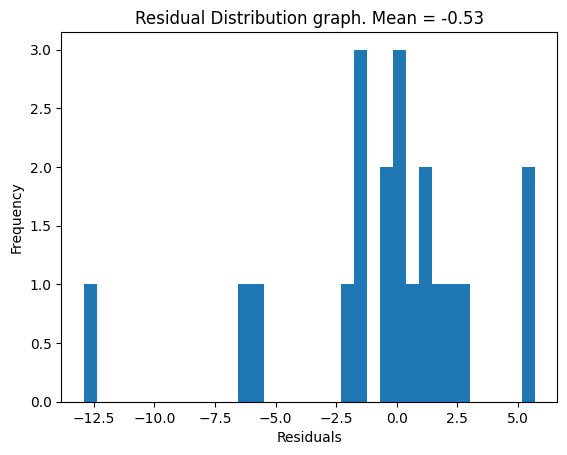

0.9664752287304014

In [8]:
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Ridge regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		17.84
Score		96.37%


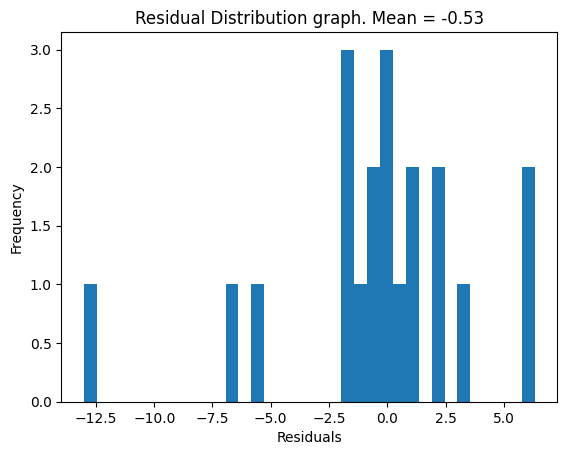

0.9636826066282668

In [9]:
from sklearn import linear_model

model = linear_model.Ridge()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Lasso regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		15.52
Score		96.84%


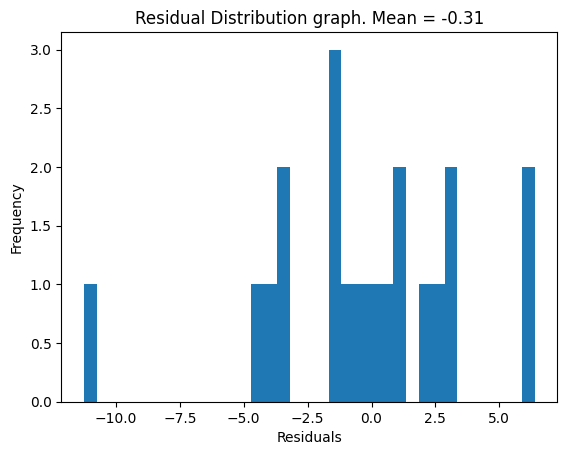

0.9684024441172947

In [10]:
from sklearn import linear_model

model = linear_model.Lasso()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Least Angle regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		15.77
Score		96.79%


c:\Users\rapha\OneDrive\Documentos\GitHub\projects-tcc-imt-2023\venv\lib\site-packages\sklearn\linear_model\_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.386e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\rapha\OneDrive\Documentos\GitHub\projects-tcc-imt-2023\venv\lib\site-packages\sklearn\linear_model\_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.234e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\rapha\OneDrive\Documentos\GitHub\projects-tcc-imt-2023\venv\lib\site-packages\sklearn\linear_model\_least_angle.py:648: ConvergenceWarning: Regressors in active set degenerate. Droppi

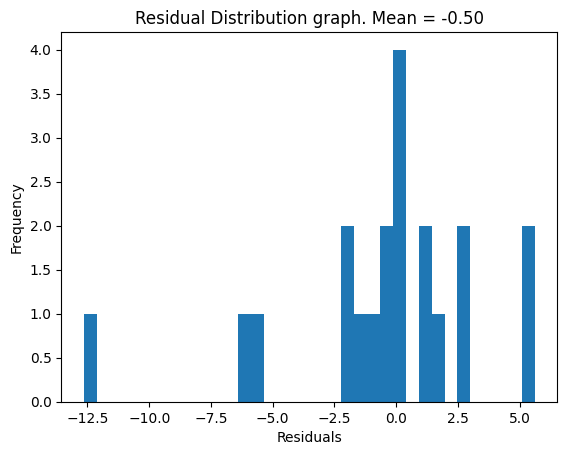

0.967901382147881

In [11]:
from sklearn import linear_model

model = linear_model.Lars()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### ElasticNet regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		24.32
Score		95.05%


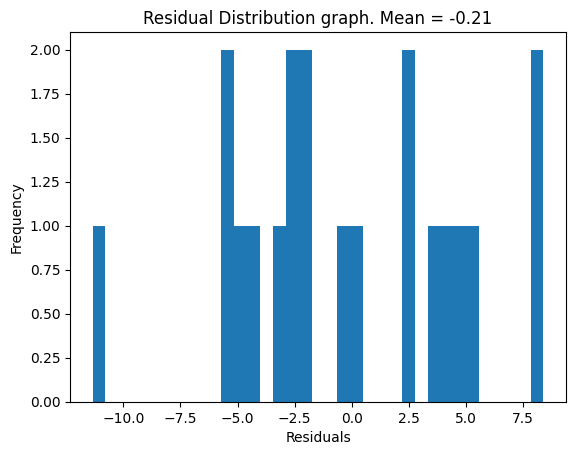

0.9504793225044775

In [12]:
from sklearn import linear_model

model = linear_model.ElasticNet()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Bayesian Ridge regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		17.58
Score		96.42%


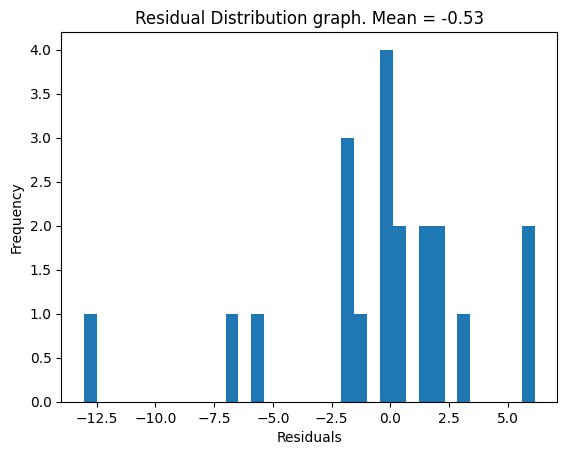

0.9642012045329952

In [13]:
from sklearn import linear_model

model = linear_model.BayesianRidge()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Stochastic Gradient Descent regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		17.60
Score		96.42%


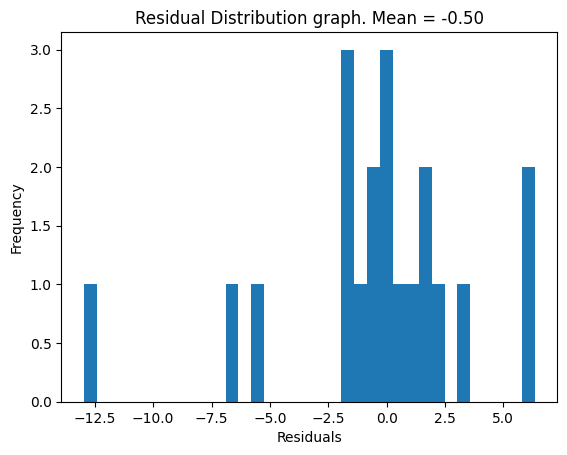

0.9641657032113975

In [14]:
from sklearn import linear_model

model = linear_model.SGDRegressor()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Theil-Sen regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		16.44
Score		96.65%


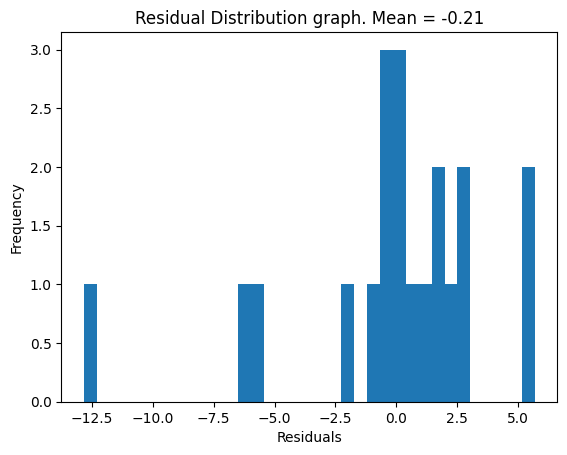

0.966530785788497

In [15]:
from sklearn import linear_model

model = linear_model.TheilSenRegressor()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Huber regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		15.14
Score		96.92%


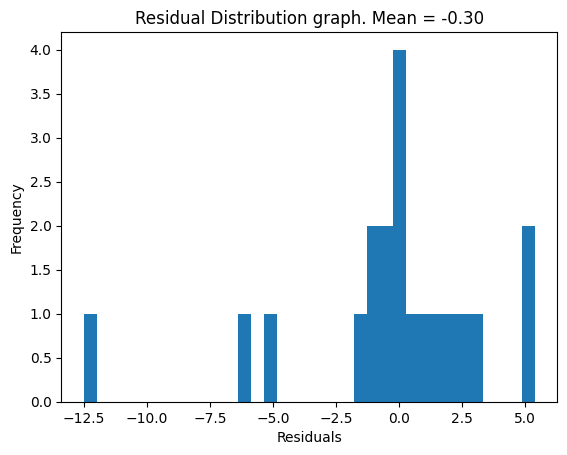

0.9691727771964578

In [16]:
from sklearn import linear_model

model = linear_model.HuberRegressor()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Poisson regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		26.39
Score		95.83%


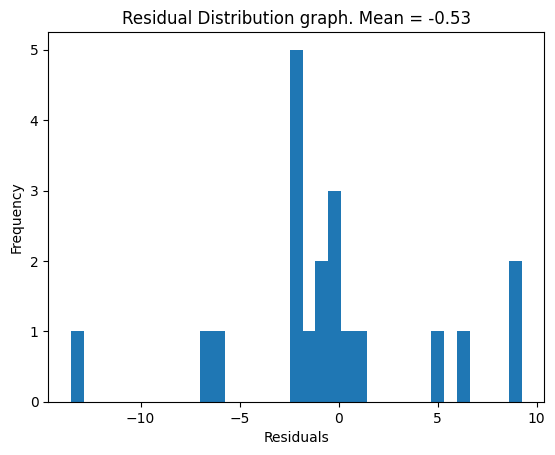

0.9583028686265116

In [17]:
from sklearn import linear_model

model = linear_model.PoissonRegressor()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

## Support Vector Machine

### Epsilon-Support Vector regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		240.93
Score		50.95%


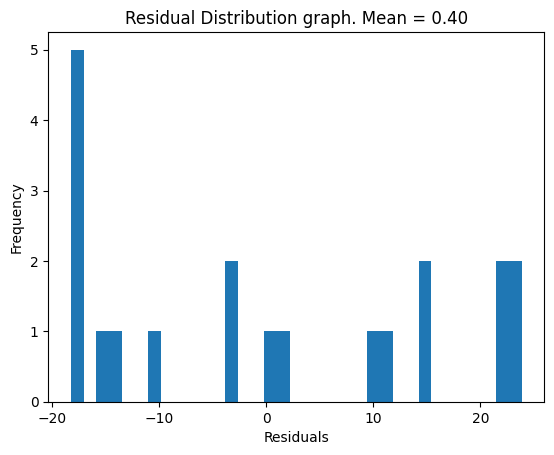

0.5094829068468697

In [18]:
from sklearn import svm

model = svm.SVR()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Nu Support Vector regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		343.93
Score		29.98%


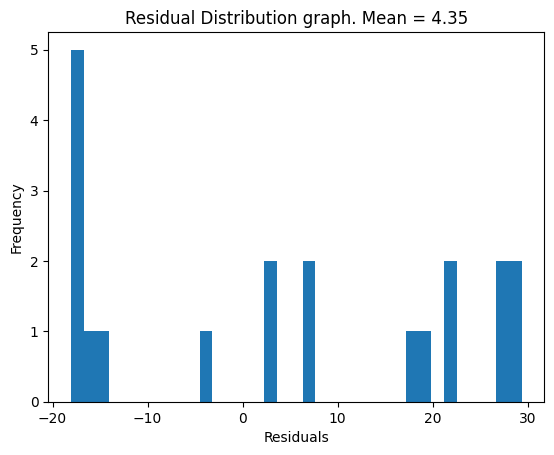

0.29978669702311844

In [19]:
from sklearn import svm

model = svm.NuSVR()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

## Nearest Neighbors

In [20]:
k = 3

### K-nearest neighbors based regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		15.01
Score		96.94%


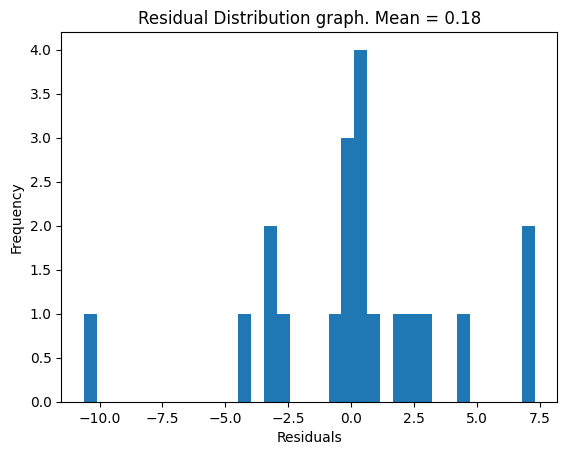

0.9694354630484285

In [21]:
from sklearn import neighbors

model = neighbors.KNeighborsRegressor(k)
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

### Neighbors within a fixed radius based regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		49.53
Score		89.92%


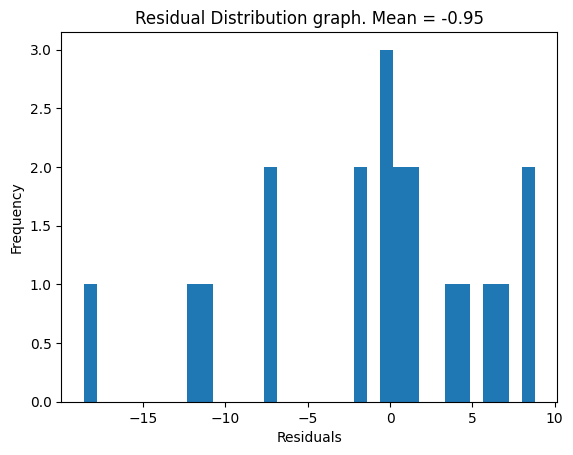

0.899156666125867

In [22]:
from sklearn import neighbors

model = neighbors.RadiusNeighborsRegressor(k)
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

## Gaussian Processes

### Gaussian process regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		16.47
Score		96.65%


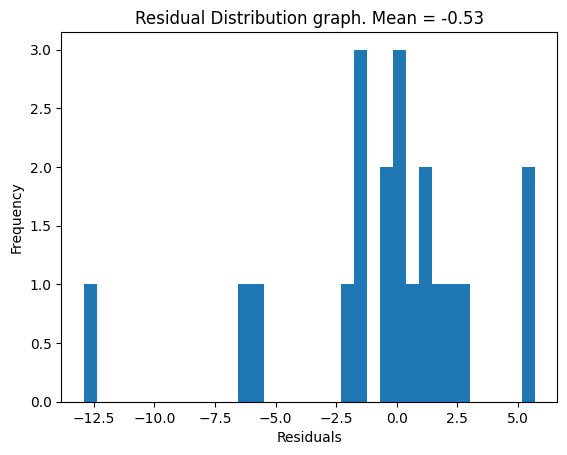

0.9664751883950287

In [23]:
from sklearn import gaussian_process

model = gaussian_process.GaussianProcessRegressor()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

## Decision Trees

### Decision tree regressor

Training DecisionTreeRegressor model
0.5%	training time left 0:00:02s
1.0%	training time left 0:00:02s
1.5%	training time left 0:00:02s
2.0%	training time left 0:00:02s
2.5%	training time left 0:00:02s
3.0%	training time left 0:00:02s
3.5%	training time left 0:00:02s
4.0%	training time left 0:00:02s
4.5%	training time left 0:00:02s
5.0%	training time left 0:00:02s
5.5%	training time left 0:00:02s
6.0%	training time left 0:00:02s
6.5%	training time left 0:00:02s
7.0%	training time left 0:00:02s
7.5%	training time left 0:00:02s
8.0%	training time left 0:00:02s
8.5%	training time left 0:00:02s
9.0%	training time left 0:00:02s
9.5%	training time left 0:00:01s
10.0%	training time left 0:00:01s
10.5%	training time left 0:00:01s
11.0%	training time left 0:00:01s
11.5%	training time left 0:00:01s
12.0%	training time left 0:00:01s
12.5%	training time left 0:00:01s
13.0%	training time left 0:00:01s
13.5%	training time left 0:00:01s
14.0%	training time left 0:00:01s
14.5%	training time left 0:00:

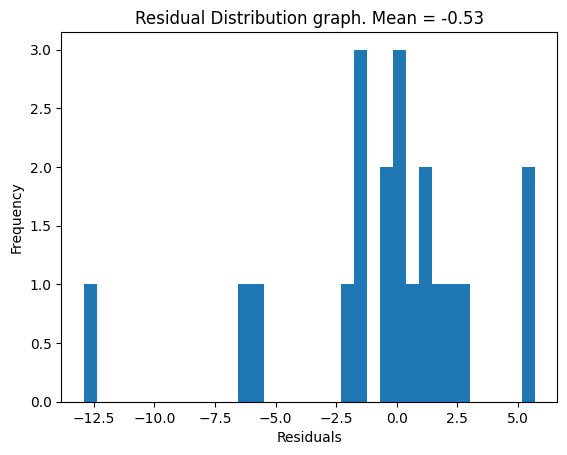

In [24]:
from sklearn import tree

model = None
try:
    model = load_instance('./models-persisted/DecisionTreeRegressor.pkl')
    print()

    model_summary(y_test, X_test, model)
except:
    model = tree.DecisionTreeRegressor()
    model = get_best_from_simple_fit_model(
        model, X_train, y_train, X_test, y_test
    )

    print()

    model_summary(y_test, X_test, model)

### Extremely randomized tree regressor

Training ExtraTreeRegressor model
0.5%	training time left 0:00:02s
1.0%	training time left 0:00:02s
1.5%	training time left 0:00:02s
2.0%	training time left 0:00:02s
2.5%	training time left 0:00:02s
3.0%	training time left 0:00:02s
3.5%	training time left 0:00:02s
4.0%	training time left 0:00:02s
4.5%	training time left 0:00:02s
5.0%	training time left 0:00:02s
5.5%	training time left 0:00:02s
6.0%	training time left 0:00:02s
6.5%	training time left 0:00:02s
7.0%	training time left 0:00:02s
7.5%	training time left 0:00:02s
8.0%	training time left 0:00:02s
8.5%	training time left 0:00:02s
9.0%	training time left 0:00:02s
9.5%	training time left 0:00:02s
10.0%	training time left 0:00:02s
10.5%	training time left 0:00:02s
11.0%	training time left 0:00:02s
11.5%	training time left 0:00:02s
12.0%	training time left 0:00:02s
12.5%	training time left 0:00:02s
13.0%	training time left 0:00:01s
13.5%	training time left 0:00:01s
14.0%	training time left 0:00:01s
14.5%	training time left 0:00:01s

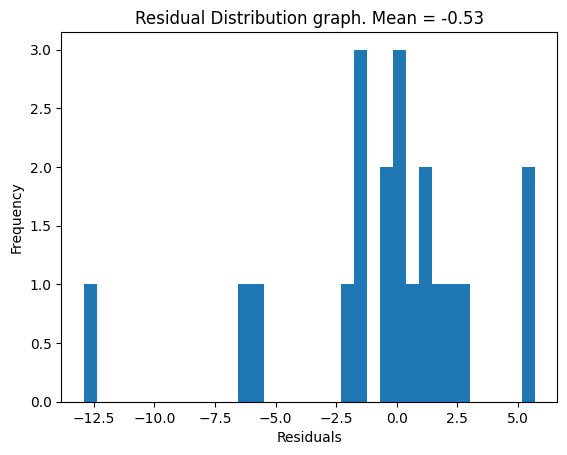

In [25]:
from sklearn import tree

model = None
try:
    model = load_instance('./models-persisted/ExtraTreeRegressor.pkl')
    print()

    model_summary(y_test, X_test, model)
except:
    model = tree.ExtraTreeRegressor()
    model = get_best_from_simple_fit_model(
        model, X_train, y_train, X_test, y_test
    )

    print()

    model_summary(y_test, X_test, model)

## Ensemble methods

Regressors are `not` idempotent

### Bagging regressor

Training BaggingRegressor model
0.5%	training time left 0:00:11s
1.0%	training time left 0:00:11s
1.5%	training time left 0:00:11s
2.0%	training time left 0:00:11s
2.5%	training time left 0:00:11s
3.0%	training time left 0:00:11s
3.5%	training time left 0:00:11s
4.0%	training time left 0:00:11s
4.5%	training time left 0:00:11s
5.0%	training time left 0:00:11s
5.5%	training time left 0:00:11s
6.0%	training time left 0:00:11s
6.5%	training time left 0:00:11s
7.0%	training time left 0:00:10s
7.5%	training time left 0:00:10s
8.0%	training time left 0:00:10s
8.5%	training time left 0:00:10s
9.0%	training time left 0:00:10s
9.5%	training time left 0:00:10s
10.0%	training time left 0:00:10s
10.5%	training time left 0:00:10s
11.0%	training time left 0:00:10s
11.5%	training time left 0:00:10s
12.0%	training time left 0:00:10s
12.5%	training time left 0:00:10s
13.0%	training time left 0:00:10s
13.5%	training time left 0:00:10s
14.0%	training time left 0:00:10s
14.5%	training time left 0:00:10s
1

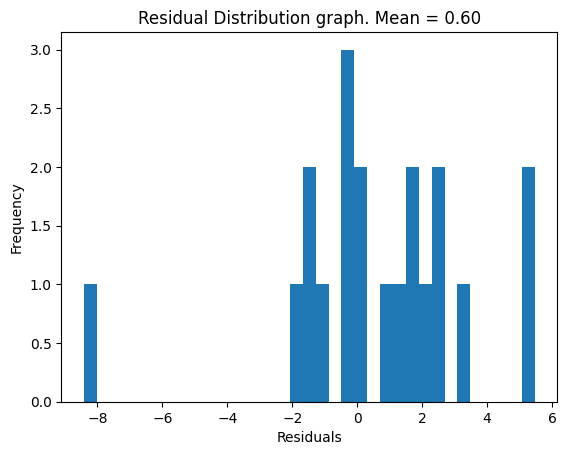

In [26]:
from sklearn import ensemble

model = None
try:
    model = load_instance('./models-persisted/BaggingRegressor.pkl')
    print()

    model_summary(y_test, X_test, model)
except:
    model = ensemble.BaggingRegressor()
    model = get_best_from_simple_fit_model(
        model, X_train, y_train, X_test, y_test
    )

    print()

    model_summary(y_test, X_test, model)

### AdaBoost regressor

Training AdaBoostRegressor model
0.5%	training time left 0:00:08s
1.0%	training time left 0:00:07s
1.5%	training time left 0:00:06s
2.0%	training time left 0:00:06s
2.5%	training time left 0:00:06s
3.0%	training time left 0:00:06s
3.5%	training time left 0:00:06s
4.0%	training time left 0:00:06s
4.5%	training time left 0:00:06s
5.0%	training time left 0:00:06s
5.5%	training time left 0:00:06s
6.0%	training time left 0:00:06s
6.5%	training time left 0:00:06s
7.0%	training time left 0:00:06s
7.5%	training time left 0:00:06s
8.0%	training time left 0:00:06s
8.5%	training time left 0:00:06s
9.0%	training time left 0:00:06s
9.5%	training time left 0:00:06s
10.0%	training time left 0:00:06s
10.5%	training time left 0:00:06s
11.0%	training time left 0:00:05s
11.5%	training time left 0:00:05s
12.0%	training time left 0:00:05s
12.5%	training time left 0:00:05s
13.0%	training time left 0:00:05s
13.5%	training time left 0:00:05s
14.0%	training time left 0:00:05s
14.5%	training time left 0:00:05s


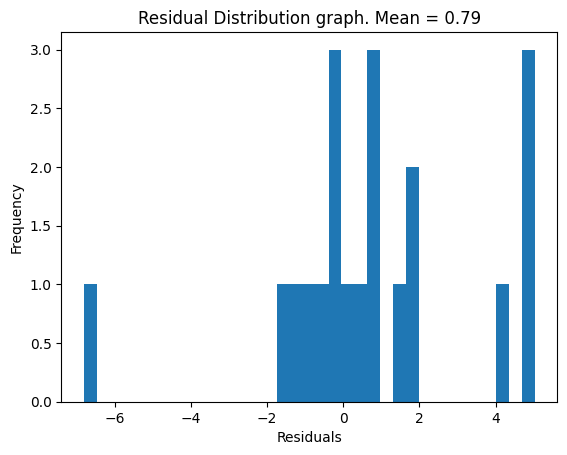

In [27]:
from sklearn import ensemble

model = None
try:
    model = load_instance('./models-persisted/AdaBoostRegressor.pkl')
    print()

    model_summary(y_test, X_test, model)
except:
    model = ensemble.AdaBoostRegressor()
    model = get_best_from_simple_fit_model(
        model, X_train, y_train, X_test, y_test
    )

    print()

    model_summary(y_test, X_test, model)

### Extra-trees regressor

This regressor differs from `tree.ExtraTreeRegressor` because it uses averaging to improve the predictive accuracy and control over-fitting using a number of randomized decision trees.

Training ExtraTreesRegressor model
0.5%	training time left 0:00:57s
1.0%	training time left 0:00:56s
1.5%	training time left 0:00:55s
2.0%	training time left 0:00:55s
2.5%	training time left 0:00:54s
3.0%	training time left 0:00:54s
3.5%	training time left 0:00:53s
4.0%	training time left 0:00:53s
4.5%	training time left 0:00:53s
5.0%	training time left 0:00:52s
5.5%	training time left 0:00:52s
6.0%	training time left 0:00:51s
6.5%	training time left 0:00:51s
7.0%	training time left 0:00:51s
7.5%	training time left 0:00:51s
8.0%	training time left 0:00:51s
8.5%	training time left 0:00:51s
9.0%	training time left 0:00:51s
9.5%	training time left 0:00:51s
10.0%	training time left 0:00:50s
10.5%	training time left 0:00:50s
11.0%	training time left 0:00:50s
11.5%	training time left 0:00:50s
12.0%	training time left 0:00:50s
12.5%	training time left 0:00:50s
13.0%	training time left 0:00:49s
13.5%	training time left 0:00:49s
14.0%	training time left 0:00:49s
14.5%	training time left 0:00:49

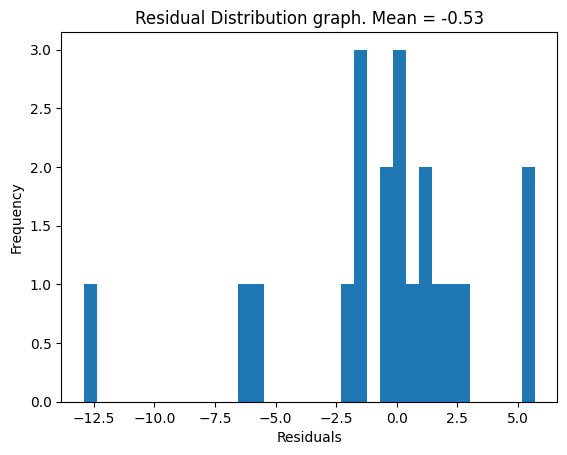

In [28]:
from sklearn import ensemble

model = None
try:
    model = load_instance('./models-persisted/ExtraTreesRegressor.pkl')
    print()

    model_summary(y_test, X_test, model)
except:
    model = ensemble.ExtraTreesRegressor()
    model = get_best_from_simple_fit_model(
        model, X_train, y_train, X_test, y_test
    )

    print()

    model_summary(y_test, X_test, model)

### Random forest regressor

Training RandomForestRegressor model
0.5%	training time left 0:01:15s
1.0%	training time left 0:01:15s
1.5%	training time left 0:01:14s
2.0%	training time left 0:01:14s
2.5%	training time left 0:01:14s
3.0%	training time left 0:01:13s
3.5%	training time left 0:01:13s
4.0%	training time left 0:01:13s
4.5%	training time left 0:01:12s
5.0%	training time left 0:01:12s
5.5%	training time left 0:01:11s
6.0%	training time left 0:01:10s
6.5%	training time left 0:01:10s
7.0%	training time left 0:01:09s
7.5%	training time left 0:01:09s
8.0%	training time left 0:01:09s
8.5%	training time left 0:01:08s
9.0%	training time left 0:01:08s
9.5%	training time left 0:01:08s
10.0%	training time left 0:01:07s
10.5%	training time left 0:01:07s
11.0%	training time left 0:01:07s
11.5%	training time left 0:01:06s
12.0%	training time left 0:01:06s
12.5%	training time left 0:01:05s
13.0%	training time left 0:01:05s
13.5%	training time left 0:01:05s
14.0%	training time left 0:01:04s
14.5%	training time left 0:01:

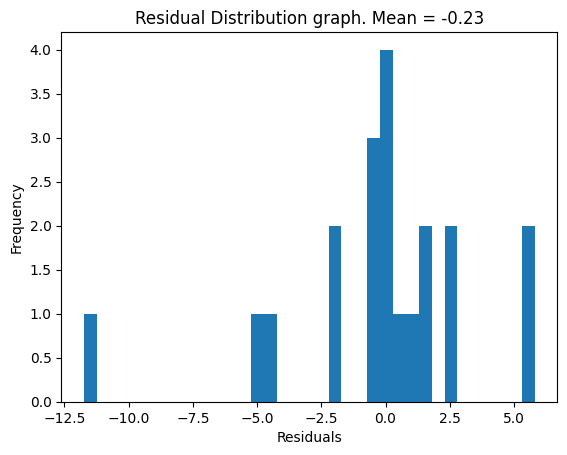

In [29]:
from sklearn import ensemble

model = None
try:
    model = load_instance('./models-persisted/RandomForestRegressor.pkl')
    print()

    model_summary(y_test, X_test, model)
except:
    model = ensemble.RandomForestRegressor()
    model = get_best_from_simple_fit_model(
        model, X_train, y_train, X_test, y_test
    )

    print()

    model_summary(y_test, X_test, model)

### Gradient Boosting for regression

Training GradientBoostingRegressor model
0.5%	training time left 0:00:24s
1.0%	training time left 0:00:23s
1.5%	training time left 0:00:23s
2.0%	training time left 0:00:23s
2.5%	training time left 0:00:23s
3.0%	training time left 0:00:23s
3.5%	training time left 0:00:22s
4.0%	training time left 0:00:22s
4.5%	training time left 0:00:22s
5.0%	training time left 0:00:22s
5.5%	training time left 0:00:22s
6.0%	training time left 0:00:22s
6.5%	training time left 0:00:22s
7.0%	training time left 0:00:22s
7.5%	training time left 0:00:21s
8.0%	training time left 0:00:21s
8.5%	training time left 0:00:21s
9.0%	training time left 0:00:21s
9.5%	training time left 0:00:21s
10.0%	training time left 0:00:21s
10.5%	training time left 0:00:21s
11.0%	training time left 0:00:21s
11.5%	training time left 0:00:21s
12.0%	training time left 0:00:20s
12.5%	training time left 0:00:20s
13.0%	training time left 0:00:20s
13.5%	training time left 0:00:20s
14.0%	training time left 0:00:20s
14.5%	training time left 0

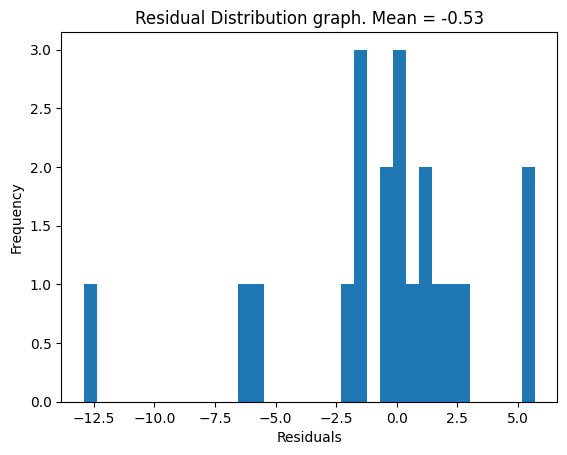

In [30]:
from sklearn import ensemble

model = None
try:
    model = load_instance('./models-persisted/GradientBoostingRegressor.pkl')
    print()

    model_summary(y_test, X_test, model)
except:
    model = ensemble.GradientBoostingRegressor()
    model = get_best_from_simple_fit_model(
        model, X_train, y_train, X_test, y_test
    )

    print()

    model_summary(y_test, X_test, model)

### Histogram-based Gradient Boosting Regression Tree

Training HistGradientBoostingRegressor model
0.5%	training time left 0:00:44s
1.0%	training time left 0:00:43s
1.5%	training time left 0:00:43s
2.0%	training time left 0:00:43s
2.5%	training time left 0:00:42s
3.0%	training time left 0:00:42s
3.5%	training time left 0:00:42s
4.0%	training time left 0:00:42s
4.5%	training time left 0:00:42s
5.0%	training time left 0:00:42s
5.5%	training time left 0:00:42s
6.0%	training time left 0:00:42s
6.5%	training time left 0:00:42s
7.0%	training time left 0:00:41s
7.5%	training time left 0:00:42s
8.0%	training time left 0:00:41s
8.5%	training time left 0:00:41s
9.0%	training time left 0:00:41s
9.5%	training time left 0:00:40s
10.0%	training time left 0:00:40s
10.5%	training time left 0:00:40s
11.0%	training time left 0:00:39s
11.5%	training time left 0:00:39s
12.0%	training time left 0:00:39s
12.5%	training time left 0:00:39s
13.0%	training time left 0:00:38s
13.5%	training time left 0:00:38s
14.0%	training time left 0:00:38s
14.5%	training time le

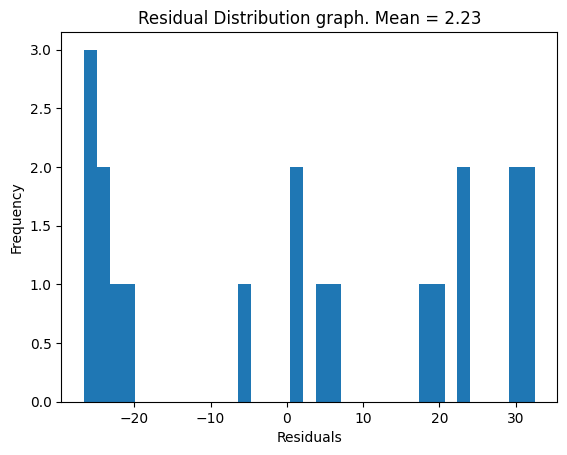

In [31]:
from sklearn import ensemble

model = None
try:
    model = load_instance('./models-persisted/HistGradientBoostingRegressor.pkl')
    print()

    model_summary(y_test, X_test, model)
except:
    model = ensemble.HistGradientBoostingRegressor()
    model = get_best_from_simple_fit_model(
        model, X_train, y_train, X_test, y_test
    )

    print()

    model_summary(y_test, X_test, model)

## Neural network models

### Multi-layer Perceptron regressor


Mean Squared Error (MSE) lower = better
Score higher = better

MSE		112.67
Score		77.06%


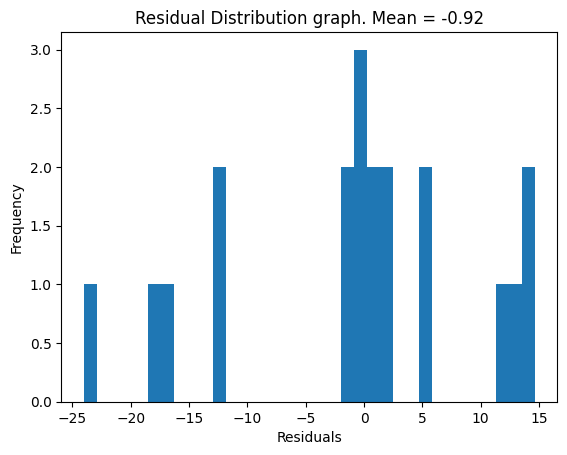

In [32]:
from sklearn import neural_network

model = None
try:
    model = load_instance('./models-persisted/MLPRegressor.pkl')
    print()

    model_summary(y_test, X_test, model)
except:
    model = neural_network.MLPRegressor(
        hidden_layer_sizes=[20, 20, 20],
        activation='tanh',
        max_iter=10000
    )
    model.fit(X_train, y_train)

    print()

    model_summary(y_test, X_test, model)

## Results

In [33]:
from json import dumps

with open('result.json', 'w') as outfile:
    outfile.write(dumps(models_result))